# WiDS Datathon 2019

The challenge is to create a model that predicts the presence of oil palm plantations in satellite imagery. Planet and Figure Eight have generously provided an annotated dataset of satellite images recently taken by Planet satellites. The dataset images are 3-meter spatial resolution, and each is labeled with whether an oil palm plantation appears in the image (0 for no plantation, 1 for any presence of a plantation).

The datathon task is to train a model that takes as input a satellite image and outputs a prediction of how likely it is that the image contains an oil palm plantation.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cv2
import os

In [93]:
'''Setting up the env'''
  
TRAIN_DIR = 'C:/Users/Karthika/Desktop/widsdatathon/2019/train_images'
TEST_DIR = 'C:/Users/Karthika/Desktop/widsdatathon/2019/leaderboard_test_data'
HOLDOUT_DIR = 'C:/Users/Karthika/Desktop/widsdatathon/2019/leaderboard_holdout_data'
trainingLabels = pd.read_csv("C:/Users/Karthika/Desktop/widsdatathon/2019/traininglabels.csv",low_memory=False)
samplesubmission = pd.read_csv("C:/Users/Karthika/Desktop/widsdatathon/2019/SampleSubmission.csv",low_memory=False)

In [4]:
'''Labelling the dataset'''
def label_img(img):
   label = trainingLabels.loc[trainingLabels['image_id'] == img, 'has_oilpalm'].iloc[0]
   score = trainingLabels.loc[trainingLabels['image_id'] == img, 'score'].iloc[0]
   return label, score


In [5]:
trainingLabels.head() # this is how the csv file looks like with top 5 entries

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


For creating training data filename of every image that is loaded is checked in trainingLabels to determine its corresponding label and score 

In [5]:
'''Creating the training data'''
def create_train_data(): 
    training_data = [] 
    for img in os.listdir(TRAIN_DIR):
        label , score = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        image = cv2.imread(path)
        training_data.append([np.array(image), label, score]) 
    np.save('train_data.npy', training_data) 
    return training_data
        

Test data for prediction consists of images from both test data and holdout data folders and while loading it is mapped against its filename which shall be used for preparing the submission file

In [6]:
'''Processing the given test data'''
def process_test_data(): 
    testing_data = [] 
    for img in os.listdir(TEST_DIR): 
        path = os.path.join(TEST_DIR, img)  
        image = cv2.imread(path) 
        testing_data.append([np.array(image), img]) 
    for img in os.listdir(HOLDOUT_DIR): 
        path = os.path.join(HOLDOUT_DIR, img)  
        image = cv2.imread(path) 
        testing_data.append([np.array(image), img])      
    np.save('test_data.npy', testing_data) 
    return testing_data 

In [7]:
train_data = create_train_data() 

As we notice the shape, we observe there are 15244 images for training of shape 256,256,3 where 3 indicates the rgb channel (in cv2 it is bgr)

In [10]:
print(len(train_data))
print(train_data[0][0].shape)

15244
(256, 256, 3)


In [11]:
test_data = process_test_data()

We observe 6534 images that needs to be tested

In [12]:
print(len(test_data))
print(test_data[0][0].shape)

6534
(256, 256, 3)


The next time you want to run this, data can be loaded using np.Load faster as we saved the data using np.save above when the function was called for the first time

In [68]:
#train_data = np.load('train_data.npy') 
#test_data = np.load('test_data.npy')

Setting up training inputs (X) and labels (Y)

In [13]:
X = np.array([i[0] for i in train_data])
Y = np.array([i[1] for i in train_data]) 
score = [i[2] for i in train_data]

In [47]:
Xtest = np.array([i[0] for i in test_data])
img_id = [i[1] for i in test_data]

Making sure if shape of X is 4 dimensional because that is what is needed for training in keras

In [14]:
print(Y.shape)
print(X.shape)

(15244,)
(15244, 256, 256, 3)


We observe out of 15244 training images only 942 images have oil palm that makes us realise that it is a very unbalanced dataset

In [15]:
np.count_nonzero(Y == 1)

942

In an attempt to make it balanced, I am trying to downsample the images having label 0 

In [16]:
a = [i for i , x in enumerate(Y) if x == 0] # a= 14302 that is no. of images without oil palm
b = [i for i in a if score[i]==1] # b = 11955 that is images in a having score = 1
c = [i for i in a if score[i]<1 and score[i]>=0.75] # c = 1624
d = [i for i in a if score[i]<0.75 and score[i]>=0.5] # d = 640
e = [i for i in a if score[i]<0.5 and score[i]>=0.25] # e = 83
f = [i for i in a if score[i]<0.25 and score[i]>=0] # f = 0

Randomly selecting few images from each of b,c,d and e 

In [17]:
import random
b = random.sample(b, 1200)
c = random.sample(c, 400)
d = random.sample(d, 260)
e = random.sample(e, 40)

In [18]:
np.count_nonzero(Y == 1)

942

So taking all of 942 has oil palm images and the other randomly selected 1900 without oil palm gives us 2842 images for training 

In [19]:
indices = [i for i , x in enumerate(Y) if x == 1]
indices.extend(b + c + d + e)
len(indices)

2842

Need to now find the selected images from X and create another variable X_n to store

In [20]:
X_n = np.array([x for i, x in enumerate(X) if i in indices])
Y_n = np.array([y for i, y in enumerate(Y) if i in indices])
score_n = [c for i, c in enumerate(score) if i in indices]
np.count_nonzero(Y_n==1)

942

In [21]:
print(X_n.shape)
print(Y_n.shape)

(2842, 256, 256, 3)
(2842,)


Trying to visualise the data 

In [135]:
Y_n[47]

0

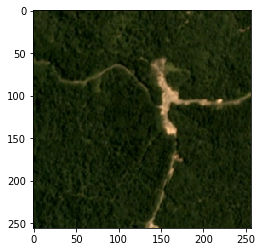

In [23]:
plt.imshow(cv2.cvtColor(X_n[47].reshape(256,256,3), cv2.COLOR_BGR2RGB))

In [24]:
index = [i for i , x in enumerate(Y_n) if x == 1] #collecting all indices having oil palm images 
index

[4,
 15,
 17,
 21,
 22,
 25,
 29,
 37,
 41,
 46,
 49,
 53,
 57,
 58,
 60,
 61,
 62,
 63,
 65,
 67,
 72,
 75,
 78,
 82,
 85,
 90,
 92,
 93,
 94,
 97,
 100,
 101,
 109,
 110,
 112,
 113,
 116,
 117,
 128,
 130,
 131,
 133,
 136,
 137,
 145,
 147,
 150,
 156,
 159,
 160,
 166,
 167,
 172,
 176,
 181,
 182,
 188,
 190,
 197,
 199,
 207,
 208,
 210,
 212,
 214,
 215,
 217,
 218,
 219,
 224,
 226,
 227,
 237,
 238,
 246,
 248,
 251,
 255,
 261,
 262,
 263,
 266,
 268,
 274,
 275,
 277,
 286,
 288,
 292,
 303,
 306,
 307,
 312,
 313,
 314,
 318,
 320,
 321,
 323,
 325,
 328,
 332,
 333,
 336,
 338,
 343,
 347,
 348,
 349,
 351,
 357,
 358,
 361,
 366,
 368,
 373,
 378,
 385,
 388,
 390,
 391,
 400,
 403,
 407,
 411,
 414,
 417,
 420,
 421,
 422,
 424,
 425,
 427,
 433,
 435,
 436,
 440,
 441,
 442,
 453,
 457,
 458,
 463,
 464,
 467,
 469,
 470,
 471,
 476,
 480,
 483,
 484,
 490,
 497,
 501,
 502,
 507,
 509,
 511,
 515,
 520,
 522,
 524,
 528,
 530,
 532,
 533,
 539,
 543,
 544,
 548,
 561,

In [25]:
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_n, Y_n, test_size=0.2, random_state=13) #splitting in training and testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)#further splitting training to training and validating

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
print(np.count_nonzero(Y_n==1))

(1818, 256, 256, 3)
(1818,)
(455, 256, 256, 3)
(455,)
(569, 256, 256, 3)
(569,)
942


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D


Using a pretrained VGG16 model available in keras, idea is initial layers of any image classification cnn model learns almost the same features so using a pretrained model can be of advantage. 

In [29]:
from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [30]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000022BC82D6278> False
<keras.layers.convolutional.Conv2D object at 0x0000022BC82D6A90> False
<keras.layers.convolutional.Conv2D object at 0x0000022BC82D68D0> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022BC82EBCF8> False
<keras.layers.convolutional.Conv2D object at 0x0000022BC82EB278> False
<keras.layers.convolutional.Conv2D object at 0x0000022B223E8BA8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022B22400898> False
<keras.layers.convolutional.Conv2D object at 0x0000022B224008D0> False
<keras.layers.convolutional.Conv2D object at 0x0000022B2241ABE0> False
<keras.layers.convolutional.Conv2D object at 0x0000022B22436710> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022B22471898> False
<keras.layers.convolutional.Conv2D object at 0x0000022B224718D0> False
<keras.layers.convolutional.Conv2D object at 0x0000022B2248FBE0> False
<keras.layers.convolutional.Conv2D object at 0x0000022B224AA710> False
<ker

In [34]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
mycnn1 = models.Sequential()
 
# Add the vgg convolutional base model
mycnn1.add(vgg_conv)
 
# Add new layers
mycnn1.add(layers.Flatten(input_shape=mycnn1.output_shape[1:]))
mycnn1.add(layers.Dense(256, activation='relu'))
mycnn1.add(layers.Dropout(0.5))
mycnn1.add(layers.Dense(1, activation='sigmoid'))
 
# Show a summary of the model. Check the number of trainable parameters
mycnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 15,468,545
Non-trainable params: 7,635,264
_________________________________________________________________


In [37]:
mycnn1.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), # using stochastic gradient decent optimizer
              loss='binary_crossentropy', #since it is a binary classification 
              metrics=['accuracy'])

In [39]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 10
epochs = 10

# used for image augmentation 
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)

train_datagen.fit(X_train)

history = mycnn1.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val))




Epoch 1/10
181/181 [==============================] - ETA: 41:54 - loss: 1.4818 - acc: 0.50 - ETA: 23:31 - loss: 1.9428 - acc: 0.55 - ETA: 17:13 - loss: 2.1587 - acc: 0.50 - ETA: 14:03 - loss: 2.3489 - acc: 0.52 - ETA: 12:08 - loss: 2.9122 - acc: 0.46 - ETA: 10:51 - loss: 2.7771 - acc: 0.48 - ETA: 9:54 - loss: 2.5069 - acc: 0.5286 - ETA: 9:11 - loss: 2.6315 - acc: 0.525 - ETA: 8:37 - loss: 2.3425 - acc: 0.577 - ETA: 8:09 - loss: 2.2697 - acc: 0.610 - ETA: 7:47 - loss: 2.0641 - acc: 0.645 - ETA: 7:27 - loss: 2.0898 - acc: 0.658 - ETA: 7:12 - loss: 1.9793 - acc: 0.669 - ETA: 6:57 - loss: 2.1210 - acc: 0.671 - ETA: 6:45 - loss: 2.1283 - acc: 0.673 - ETA: 6:33 - loss: 2.0217 - acc: 0.687 - ETA: 6:23 - loss: 1.9051 - acc: 0.705 - ETA: 6:15 - loss: 1.8661 - acc: 0.716 - ETA: 6:06 - loss: 1.7989 - acc: 0.726 - ETA: 5:58 - loss: 1.7411 - acc: 0.735 - ETA: 5:51 - loss: 1.6620 - acc: 0.742 - ETA: 5:45 - loss: 1.6822 - acc: 0.745 - ETA: 5:38 - loss: 1.6939 - acc: 0.743 - ETA: 5:33 - loss: 1.6529 

181/181 [==============================] - ETA: 2:55 - loss: 0.0204 - acc: 1.000 - ETA: 2:55 - loss: 0.3971 - acc: 0.950 - ETA: 2:54 - loss: 0.5328 - acc: 0.900 - ETA: 2:54 - loss: 0.4049 - acc: 0.925 - ETA: 2:53 - loss: 0.3967 - acc: 0.920 - ETA: 2:52 - loss: 0.3321 - acc: 0.933 - ETA: 2:51 - loss: 0.2855 - acc: 0.942 - ETA: 2:50 - loss: 0.2520 - acc: 0.950 - ETA: 2:49 - loss: 0.2247 - acc: 0.955 - ETA: 2:48 - loss: 0.2960 - acc: 0.950 - ETA: 2:47 - loss: 0.2706 - acc: 0.954 - ETA: 2:46 - loss: 0.2745 - acc: 0.941 - ETA: 2:45 - loss: 0.2653 - acc: 0.938 - ETA: 2:44 - loss: 0.2470 - acc: 0.942 - ETA: 2:43 - loss: 0.2306 - acc: 0.946 - ETA: 2:42 - loss: 0.2315 - acc: 0.943 - ETA: 2:41 - loss: 0.2192 - acc: 0.947 - ETA: 2:41 - loss: 0.2177 - acc: 0.944 - ETA: 2:40 - loss: 0.2116 - acc: 0.947 - ETA: 2:39 - loss: 0.2033 - acc: 0.950 - ETA: 2:38 - loss: 0.1949 - acc: 0.952 - ETA: 2:37 - loss: 0.2053 - acc: 0.950 - ETA: 2:36 - loss: 0.2007 - acc: 0.952 - ETA: 2:35 - loss: 0.1956 - acc: 0.954

181/181 [==============================] - ETA: 2:57 - loss: 0.0252 - acc: 1.000 - ETA: 2:45 - loss: 0.0186 - acc: 1.000 - ETA: 2:48 - loss: 0.0345 - acc: 1.000 - ETA: 2:48 - loss: 0.1836 - acc: 0.975 - ETA: 2:49 - loss: 0.1678 - acc: 0.960 - ETA: 2:48 - loss: 0.1444 - acc: 0.966 - ETA: 2:48 - loss: 0.1292 - acc: 0.971 - ETA: 2:47 - loss: 0.1180 - acc: 0.975 - ETA: 2:52 - loss: 0.1515 - acc: 0.955 - ETA: 2:51 - loss: 0.1409 - acc: 0.960 - ETA: 2:49 - loss: 0.1338 - acc: 0.963 - ETA: 2:48 - loss: 0.1526 - acc: 0.950 - ETA: 2:47 - loss: 0.1441 - acc: 0.953 - ETA: 2:46 - loss: 0.1486 - acc: 0.950 - ETA: 2:45 - loss: 0.1412 - acc: 0.953 - ETA: 2:44 - loss: 0.1345 - acc: 0.956 - ETA: 2:43 - loss: 0.1294 - acc: 0.958 - ETA: 2:42 - loss: 0.1295 - acc: 0.955 - ETA: 2:41 - loss: 0.1355 - acc: 0.952 - ETA: 2:40 - loss: 0.1307 - acc: 0.955 - ETA: 2:39 - loss: 0.1440 - acc: 0.952 - ETA: 2:38 - loss: 0.1391 - acc: 0.954 - ETA: 2:37 - loss: 0.1421 - acc: 0.952 - ETA: 2:36 - loss: 0.1538 - acc: 0.950

181/181 [==============================] - ETA: 2:56 - loss: 0.0028 - acc: 1.000 - ETA: 2:56 - loss: 0.0037 - acc: 1.000 - ETA: 2:48 - loss: 0.0041 - acc: 1.000 - ETA: 2:49 - loss: 0.0046 - acc: 1.000 - ETA: 2:49 - loss: 0.0461 - acc: 0.980 - ETA: 2:49 - loss: 0.0393 - acc: 0.983 - ETA: 2:49 - loss: 0.0383 - acc: 0.985 - ETA: 2:48 - loss: 0.0341 - acc: 0.987 - ETA: 2:47 - loss: 0.0323 - acc: 0.988 - ETA: 2:46 - loss: 0.0304 - acc: 0.990 - ETA: 2:46 - loss: 0.0282 - acc: 0.990 - ETA: 2:45 - loss: 0.0273 - acc: 0.991 - ETA: 2:44 - loss: 0.0260 - acc: 0.992 - ETA: 2:43 - loss: 0.0601 - acc: 0.985 - ETA: 2:42 - loss: 0.0572 - acc: 0.986 - ETA: 2:41 - loss: 0.0545 - acc: 0.987 - ETA: 2:40 - loss: 0.0518 - acc: 0.988 - ETA: 2:39 - loss: 0.0527 - acc: 0.988 - ETA: 2:38 - loss: 0.0502 - acc: 0.989 - ETA: 2:38 - loss: 0.0485 - acc: 0.990 - ETA: 2:37 - loss: 0.0463 - acc: 0.990 - ETA: 2:36 - loss: 0.0445 - acc: 0.990 - ETA: 2:35 - loss: 0.0438 - acc: 0.991 - ETA: 2:34 - loss: 0.0422 - acc: 0.991

181/181 [==============================] - ETA: 2:57 - loss: 0.0089 - acc: 1.000 - ETA: 2:56 - loss: 0.0066 - acc: 1.000 - ETA: 2:55 - loss: 0.0109 - acc: 1.000 - ETA: 2:49 - loss: 0.0090 - acc: 1.000 - ETA: 2:49 - loss: 0.0113 - acc: 1.000 - ETA: 2:49 - loss: 0.0109 - acc: 1.000 - ETA: 2:48 - loss: 0.0129 - acc: 1.000 - ETA: 2:48 - loss: 0.0135 - acc: 1.000 - ETA: 2:47 - loss: 0.0215 - acc: 0.988 - ETA: 2:46 - loss: 0.0227 - acc: 0.990 - ETA: 2:45 - loss: 0.0218 - acc: 0.990 - ETA: 2:44 - loss: 0.0203 - acc: 0.991 - ETA: 2:44 - loss: 0.0194 - acc: 0.992 - ETA: 2:43 - loss: 0.0189 - acc: 0.992 - ETA: 2:42 - loss: 0.0195 - acc: 0.993 - ETA: 2:41 - loss: 0.0381 - acc: 0.987 - ETA: 2:40 - loss: 0.0408 - acc: 0.988 - ETA: 2:39 - loss: 0.0553 - acc: 0.983 - ETA: 2:38 - loss: 0.0535 - acc: 0.984 - ETA: 2:37 - loss: 0.0522 - acc: 0.985 - ETA: 2:36 - loss: 0.0516 - acc: 0.985 - ETA: 2:36 - loss: 0.0500 - acc: 0.986 - ETA: 2:35 - loss: 0.0556 - acc: 0.982 - ETA: 2:34 - loss: 0.0534 - acc: 0.983

181/181 [==============================] - ETA: 2:58 - loss: 0.0232 - acc: 1.000 - ETA: 2:57 - loss: 0.0257 - acc: 1.000 - ETA: 2:56 - loss: 0.0272 - acc: 1.000 - ETA: 2:55 - loss: 0.0235 - acc: 1.000 - ETA: 2:50 - loss: 0.0212 - acc: 1.000 - ETA: 2:49 - loss: 0.0209 - acc: 1.000 - ETA: 2:49 - loss: 0.0228 - acc: 1.000 - ETA: 2:48 - loss: 0.0215 - acc: 1.000 - ETA: 2:48 - loss: 0.0251 - acc: 1.000 - ETA: 2:47 - loss: 0.0229 - acc: 1.000 - ETA: 2:46 - loss: 0.0363 - acc: 0.990 - ETA: 2:45 - loss: 0.0339 - acc: 0.991 - ETA: 2:45 - loss: 0.0316 - acc: 0.992 - ETA: 2:44 - loss: 0.0303 - acc: 0.992 - ETA: 2:43 - loss: 0.0448 - acc: 0.986 - ETA: 2:42 - loss: 0.0434 - acc: 0.987 - ETA: 2:41 - loss: 0.0411 - acc: 0.988 - ETA: 2:40 - loss: 0.0410 - acc: 0.988 - ETA: 2:39 - loss: 0.0390 - acc: 0.989 - ETA: 2:38 - loss: 0.0404 - acc: 0.990 - ETA: 2:37 - loss: 0.0387 - acc: 0.990 - ETA: 2:36 - loss: 0.0378 - acc: 0.990 - ETA: 2:35 - loss: 0.0564 - acc: 0.987 - ETA: 2:34 - loss: 0.0546 - acc: 0.987

181/181 [==============================] - ETA: 2:56 - loss: 0.0028 - acc: 1.000 - ETA: 2:56 - loss: 0.0090 - acc: 1.000 - ETA: 2:55 - loss: 0.0502 - acc: 0.966 - ETA: 2:54 - loss: 0.1069 - acc: 0.950 - ETA: 2:53 - loss: 0.0864 - acc: 0.960 - ETA: 2:50 - loss: 0.0815 - acc: 0.966 - ETA: 2:49 - loss: 0.0738 - acc: 0.971 - ETA: 2:49 - loss: 0.0686 - acc: 0.975 - ETA: 2:48 - loss: 0.0641 - acc: 0.977 - ETA: 2:47 - loss: 0.0581 - acc: 0.980 - ETA: 2:46 - loss: 0.0962 - acc: 0.963 - ETA: 2:45 - loss: 0.0900 - acc: 0.966 - ETA: 2:45 - loss: 0.0834 - acc: 0.969 - ETA: 2:44 - loss: 0.1114 - acc: 0.964 - ETA: 2:43 - loss: 0.1087 - acc: 0.966 - ETA: 2:42 - loss: 0.1032 - acc: 0.968 - ETA: 2:41 - loss: 0.0981 - acc: 0.970 - ETA: 2:40 - loss: 0.0963 - acc: 0.972 - ETA: 2:39 - loss: 0.0920 - acc: 0.973 - ETA: 2:38 - loss: 0.0991 - acc: 0.965 - ETA: 2:37 - loss: 0.0962 - acc: 0.966 - ETA: 2:36 - loss: 0.1142 - acc: 0.963 - ETA: 2:35 - loss: 0.1191 - acc: 0.956 - ETA: 2:34 - loss: 0.1158 - acc: 0.958

181/181 [==============================] - ETA: 2:57 - loss: 0.0135 - acc: 1.000 - ETA: 2:56 - loss: 0.1506 - acc: 0.950 - ETA: 2:55 - loss: 0.1903 - acc: 0.933 - ETA: 2:54 - loss: 0.1692 - acc: 0.925 - ETA: 2:53 - loss: 0.1362 - acc: 0.940 - ETA: 2:52 - loss: 0.1154 - acc: 0.950 - ETA: 2:48 - loss: 0.1053 - acc: 0.957 - ETA: 2:48 - loss: 0.1219 - acc: 0.950 - ETA: 2:47 - loss: 0.1100 - acc: 0.955 - ETA: 2:46 - loss: 0.1020 - acc: 0.960 - ETA: 2:45 - loss: 0.0945 - acc: 0.963 - ETA: 2:45 - loss: 0.0879 - acc: 0.966 - ETA: 2:44 - loss: 0.0813 - acc: 0.969 - ETA: 2:43 - loss: 0.0806 - acc: 0.971 - ETA: 2:42 - loss: 0.0756 - acc: 0.973 - ETA: 2:41 - loss: 0.0718 - acc: 0.975 - ETA: 2:40 - loss: 0.0679 - acc: 0.976 - ETA: 2:39 - loss: 0.0964 - acc: 0.966 - ETA: 2:38 - loss: 0.0922 - acc: 0.968 - ETA: 2:37 - loss: 0.0888 - acc: 0.970 - ETA: 2:37 - loss: 0.0846 - acc: 0.971 - ETA: 2:36 - loss: 0.0816 - acc: 0.972 - ETA: 2:35 - loss: 0.0786 - acc: 0.973 - ETA: 2:34 - loss: 0.0774 - acc: 0.975

181/181 [==============================] - ETA: 2:57 - loss: 0.0029 - acc: 1.000 - ETA: 2:56 - loss: 0.0035 - acc: 1.000 - ETA: 2:55 - loss: 0.0109 - acc: 1.000 - ETA: 2:54 - loss: 0.0110 - acc: 1.000 - ETA: 2:53 - loss: 0.0099 - acc: 1.000 - ETA: 2:52 - loss: 0.0143 - acc: 1.000 - ETA: 2:51 - loss: 0.0481 - acc: 0.985 - ETA: 2:48 - loss: 0.0432 - acc: 0.987 - ETA: 2:47 - loss: 0.0439 - acc: 0.988 - ETA: 2:46 - loss: 0.0431 - acc: 0.990 - ETA: 2:46 - loss: 0.0412 - acc: 0.990 - ETA: 2:45 - loss: 0.0419 - acc: 0.991 - ETA: 2:44 - loss: 0.0390 - acc: 0.992 - ETA: 2:43 - loss: 0.0368 - acc: 0.992 - ETA: 2:42 - loss: 0.0344 - acc: 0.993 - ETA: 2:41 - loss: 0.0478 - acc: 0.987 - ETA: 2:40 - loss: 0.0451 - acc: 0.988 - ETA: 2:39 - loss: 0.0434 - acc: 0.988 - ETA: 2:39 - loss: 0.0430 - acc: 0.989 - ETA: 2:38 - loss: 0.0419 - acc: 0.990 - ETA: 2:37 - loss: 0.0402 - acc: 0.990 - ETA: 2:36 - loss: 0.0564 - acc: 0.986 - ETA: 2:35 - loss: 0.0745 - acc: 0.982 - ETA: 2:34 - loss: 0.0864 - acc: 0.975

181/181 [==============================] - ETA: 2:57 - loss: 0.4130 - acc: 0.900 - ETA: 2:56 - loss: 0.2358 - acc: 0.950 - ETA: 2:55 - loss: 0.1820 - acc: 0.966 - ETA: 2:54 - loss: 0.1380 - acc: 0.975 - ETA: 2:54 - loss: 0.1111 - acc: 0.980 - ETA: 2:53 - loss: 0.1118 - acc: 0.966 - ETA: 2:52 - loss: 0.1158 - acc: 0.957 - ETA: 2:51 - loss: 0.1048 - acc: 0.962 - ETA: 2:48 - loss: 0.0963 - acc: 0.966 - ETA: 2:47 - loss: 0.0873 - acc: 0.970 - ETA: 2:46 - loss: 0.0805 - acc: 0.972 - ETA: 2:45 - loss: 0.0966 - acc: 0.966 - ETA: 2:44 - loss: 0.0967 - acc: 0.961 - ETA: 2:44 - loss: 0.0900 - acc: 0.964 - ETA: 2:43 - loss: 0.0867 - acc: 0.966 - ETA: 2:42 - loss: 0.0819 - acc: 0.968 - ETA: 2:41 - loss: 0.0995 - acc: 0.964 - ETA: 2:40 - loss: 0.0947 - acc: 0.966 - ETA: 2:39 - loss: 0.0972 - acc: 0.963 - ETA: 2:38 - loss: 0.0928 - acc: 0.965 - ETA: 2:37 - loss: 0.0890 - acc: 0.966 - ETA: 2:36 - loss: 0.0901 - acc: 0.963 - ETA: 2:35 - loss: 0.0871 - acc: 0.965 - ETA: 2:34 - loss: 0.0843 - acc: 0.966

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
print('acc:', acc)
print('val_acc:', val_acc)
print('loss:' , loss)
print('val_loss:', val_loss)

acc: [0.9116022042641982, 0.9540929140242855, 0.9640486659729375, 0.9679203483119475, 0.9684734457889489, 0.9751106158426378, 0.9717920313103009, 0.9701327385496249, 0.9773230050913001, 0.9789822958739458]
val_acc: [0.9648351603811913, 0.9648351590711992, 0.9670329617929982, 0.9604395549375933, 0.9692307645147973, 0.9736263673384111, 0.9714285659266042, 0.9736263686484032, 0.9758241713702024, 0.9758241713702024]
loss: [0.4305443077062601, 0.14707338077387572, 0.11794974877544374, 0.10892138972913741, 0.09794963657890371, 0.09038088046901847, 0.09677700804330225, 0.08895025437296496, 0.06610821354933355, 0.075833186747557]
val_loss: [0.17398277167000573, 0.13926366371726925, 0.12917137311152335, 0.12697631711841326, 0.11098240012722602, 0.09695306769828056, 0.09400280301937587, 0.07752884796738707, 0.09960728962515522, 0.0921195640723134]


In [46]:
mycnn1.evaluate(X_test, y_test, batch_size = 10)

569/569 [==============================] - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 33 - ETA: 32 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 60s 105ms/step


[0.10189760806276461, 0.9771528975196798]

In [87]:
mycnn1.save('wids.model') #saving the model for future direct use

Now that the model is trained and gives an accuracy of 97.7% we can give it the actual testing data and visualise its prediction 

[1.]


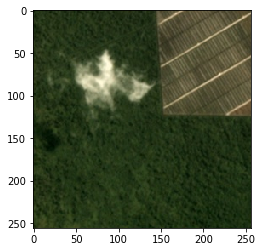

In [103]:
plt.imshow(cv2.cvtColor(Xtest[243].reshape(256,256,3), cv2.COLOR_BGR2RGB)) 
predict = mycnn1.predict(Xtest[243].reshape(1, 256, 256, 3))
print(pred[0])
#25,41,86,88,112,122,1017 for 1
#96 confusing

In [104]:
pred = mycnn1.predict(Xtest, batch_size=10)


In [114]:
print(pred.shape)


(6534, 1)


Using histogram to visualise the predictions which shows a lot of images lying near zero that is referring to images that don't have oil palm and the images that give a prediction value near 1 is more likely to contain oil palm

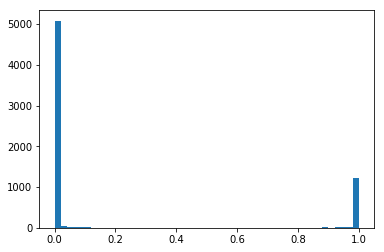

In [133]:
import matplotlib.pyplot as plt
plt.hist(pred,bins=50)
plt.show()

Keeping a threshold of 0.2 and considering all the probabilities that lie above it in label 1 category that is actually images having oil palm and the rest as label 0 

In [128]:
for i, id in enumerate(img_id):
    prediction = 1 if pred[i]>0.2 else 0
    samplesubmission.loc[samplesubmission['image_id'] == id, 'has_oilpalm'] = prediction

samplesubmission.to_csv("submit_kk9.csv", index=False)

Achieved a leaderboard score of 0.95358 